# Credit Card Fraud Detection & Customer Segmentation
## Modified Version: Clustering Non-Fraud Customers for Credit Limit Assignment

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Scikit-learn - Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn - Metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    silhouette_score
)

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print(f"✓ Random seed set to {RANDOM_STATE} for reproducibility")

✓ Libraries imported successfully
✓ Random seed set to 42 for reproducibility


In [2]:
# Load dataset
# NOTE: Update this path to your actual data file location
df = pd.read_csv("creditcard_2023.csv")

# Display basic information
print(f"\n{'='*60}")
print("DATASET OVERVIEW")
print(f"{'='*60}")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nColumn Names:\n{df.columns.tolist()}")
print(f"\nFirst 5 rows:")
df.head()


DATASET OVERVIEW
Shape: 568,630 rows × 31 columns
Memory Usage: 134.49 MB

Column Names:
['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

First 5 rows:


,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,-0.987020,0.293438,-0.941386,0.549020,1.804879,0.215598,0.512307,0.333644,0.124270,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,0.140107,1.564246,0.574074,0.627719,0.706121,0.789188,0.403810,0.201799,-0.340687,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,-0.272985,0.659201,0.805173,0.616874,3.069025,-0.577514,0.886526,0.239442,-2.366079,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,-0.752581,0.737483,0.592994,0.559535,-0.697664,-0.030669,0.242629,2.178616,-1.345060,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,-1.203171,1.029577,1.439310,0.241454,0.153008,0.224538,0.366466,0.291782,0.445317,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0



TARGET VARIABLE ANALYSIS

Class Distribution:
Class 0 (Legitimate/Non-Fraud): 284,315 (50.00%)
Class 1 (Fraud): 284,315 (50.00%)


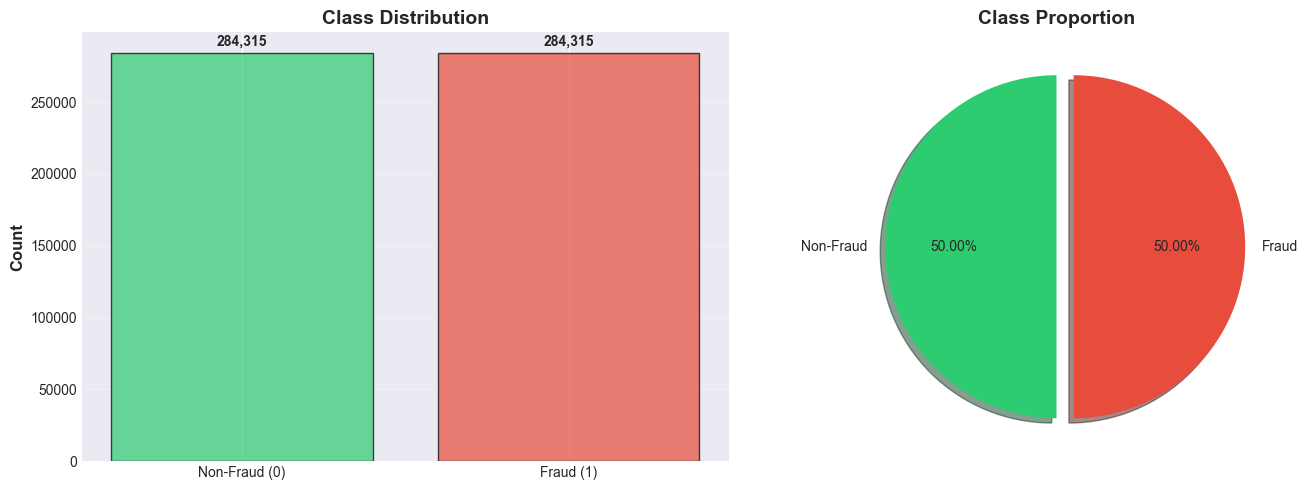

In [3]:
# Target Variable Distribution
print(f"\n{'='*60}")
print("TARGET VARIABLE ANALYSIS")
print(f"{'='*60}")

class_distribution = df['Class'].value_counts()
class_percentage = df['Class'].value_counts(normalize=True) * 100

print(f"\nClass Distribution:")
print(f"Class 0 (Legitimate/Non-Fraud): {class_distribution[0]:,} ({class_percentage[0]:.2f}%)")
print(f"Class 1 (Fraud): {class_distribution[1]:,} ({class_percentage[1]:.2f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(['Non-Fraud (0)', 'Fraud (1)'], class_distribution.values, 
            color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_distribution.values):
    axes[0].text(i, v + 5000, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(class_distribution.values, labels=['Non-Fraud', 'Fraud'], 
            autopct='%1.2f%%', colors=colors, startangle=90, 
            explode=(0, 0.1), shadow=True)
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Customer Segmentation: Clustering Non-Fraud Customers
### Goal: Segment legitimate customers into Low, Medium, and High risk tiers for credit limit assignment

In [4]:
print(f"\n{'='*60}")
print("FILTERING NON-FRAUD TRANSACTIONS")
print(f"{'='*60}")

# Filter only non-fraud transactions (Class = 0)
df_non_fraud = df[df['Class'] == 0].copy()

print(f"\nOriginal Dataset: {df.shape[0]:,} transactions")
print(f"Fraud Transactions: {(df['Class'] == 1).sum():,}")
print(f"Non-Fraud Transactions: {df_non_fraud.shape[0]:,}")
print(f"\nPercentage of Non-Fraud: {(df_non_fraud.shape[0]/df.shape[0])*100:.2f}%")

# Prepare features for clustering (exclude 'id' and 'Class')
feature_cols = [col for col in df_non_fraud.columns if col not in ['id', 'Class']]
X_non_fraud = df_non_fraud[feature_cols]

print(f"\nFeatures for clustering: {len(feature_cols)}")
print(f"Feature matrix shape: {X_non_fraud.shape}")


FILTERING NON-FRAUD TRANSACTIONS

Original Dataset: 568,630 transactions
Fraud Transactions: 284,315
Non-Fraud Transactions: 284,315

Percentage of Non-Fraud: 50.00%

Features for clustering: 29
Feature matrix shape: (284315, 29)


In [5]:
print(f"\n{'='*60}")
print("FEATURE SCALING & DIMENSIONALITY REDUCTION")
print(f"{'='*60}")

# Scale features
scaler = StandardScaler()
X_non_fraud_scaled = scaler.fit_transform(X_non_fraud)

print(f"\n✓ Features scaled using StandardScaler")
print(f"  Mean ≈ 0, Std Dev ≈ 1 for all features")

# Apply PCA for dimensionality reduction (optional: for visualization)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_non_fraud_scaled)

print(f"\n✓ PCA transformation complete")
print(f"  Original Dimensions: {X_non_fraud_scaled.shape[1]}")
print(f"  Reduced Dimensions: {X_pca.shape[1]}")
print(f"\nExplained Variance Ratio:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]*100:.2f}%)")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f} ({pca.explained_variance_ratio_[1]*100:.2f}%)")
print(f"  Total: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")


FEATURE SCALING & DIMENSIONALITY REDUCTION

✓ Features scaled using StandardScaler
  Mean ≈ 0, Std Dev ≈ 1 for all features

✓ PCA transformation complete
  Original Dimensions: 29
  Reduced Dimensions: 2

Explained Variance Ratio:
  PC1: 0.0571 (5.71%)
  PC2: 0.0518 (5.18%)
  Total: 0.1089 (10.89%)



OPTIMAL NUMBER OF CLUSTERS - ELBOW METHOD

Testing K values from 2 to 10...

K=2: Inertia=7893853.26, Silhouette Score=0.0604
K=3: Inertia=7651848.15, Silhouette Score=0.0575
K=4: Inertia=7456554.02, Silhouette Score=0.0589
K=5: Inertia=7255728.80, Silhouette Score=0.0618
K=6: Inertia=7106542.21, Silhouette Score=0.0621
K=7: Inertia=6879501.73, Silhouette Score=0.0706
K=8: Inertia=6744922.93, Silhouette Score=0.0742
K=9: Inertia=6619082.66, Silhouette Score=0.0729
K=10: Inertia=6468177.90, Silhouette Score=0.0747


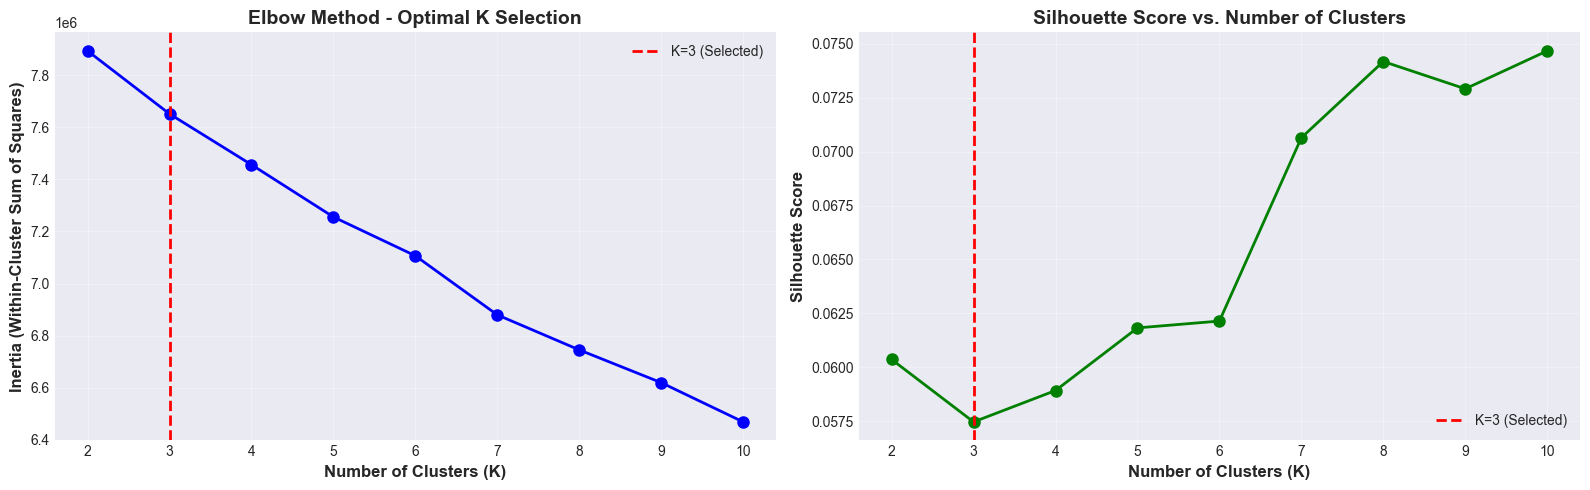


✓ Optimal number of clusters selected: K=3


In [6]:
print(f"\n{'='*60}")
print("OPTIMAL NUMBER OF CLUSTERS - ELBOW METHOD")
print(f"{'='*60}")

# Test different numbers of clusters to find optimal k
inertias = []
silhouette_scores = []
K_range = range(2, 11)

print(f"\nTesting K values from 2 to 10...\n")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_non_fraud_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_non_fraud_scaled, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette_scores[-1]:.4f}")

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Elbow curve
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].axvline(x=3, color='r', linestyle='--', linewidth=2, label='K=3 (Selected)')
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method - Optimal K Selection', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend()

# Silhouette scores
axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].axvline(x=3, color='r', linestyle='--', linewidth=2, label='K=3 (Selected)')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score vs. Number of Clusters', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n✓ Optimal number of clusters selected: K=3")

In [7]:
print(f"\n{'='*60}")
print("KMEANS CLUSTERING - 3 CLUSTERS (LOW, MEDIUM, HIGH)")
print(f"{'='*60}")

# Apply KMeans with 3 clusters on scaled features
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans.fit_predict(X_non_fraud_scaled)

# Add cluster labels to dataframe
df_non_fraud['Cluster'] = cluster_labels

# Cluster distribution
print(f"\nCluster Distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"  Cluster {cluster}: {count:,} customers ({count/len(cluster_labels)*100:.2f}%)")

# Calculate cluster statistics to determine risk levels
print(f"\n{'='*60}")
print("CLUSTER CHARACTERISTICS")
print(f"{'='*60}")

cluster_stats = df_non_fraud.groupby('Cluster')[feature_cols].mean()
print("\nCluster Mean Values (First 5 Features):")
print(cluster_stats.iloc[:, :5])

# Calculate average transaction amount per cluster (using V1-V28 as proxy)
cluster_avg_values = cluster_stats.mean(axis=1).sort_values()
print(f"\nAverage Feature Values per Cluster (Overall):")
for cluster, avg in cluster_avg_values.items():
    print(f"  Cluster {cluster}: {avg:.4f}")


KMEANS CLUSTERING - 3 CLUSTERS (LOW, MEDIUM, HIGH)

Cluster Distribution:
  Cluster 0: 22,224 customers (7.82%)
  Cluster 1: 135,595 customers (47.69%)
  Cluster 2: 126,496 customers (44.49%)

CLUSTER CHARACTERISTICS

Cluster Mean Values (First 5 Features):
               V1        V2        V3        V4        V5
Cluster                                                  
0        0.374759 -0.285710  0.807207 -0.659301  0.363324
1       -0.154936 -0.339226  0.938489 -0.882741  0.474180
2        1.236998 -0.691732  0.385279 -0.592136  0.189011

Average Feature Values per Cluster (Overall):
  Cluster 0: 412.7362
  Cluster 2: 414.4412
  Cluster 1: 415.5450


In [8]:
print(f"\n{'='*60}")
print("CREDIT LIMIT ASSIGNMENT")
print(f"{'='*60}")

# Map clusters to risk tiers based on average values
# Lower average values = Lower risk = Higher credit limit
cluster_to_tier = {}
sorted_clusters = cluster_avg_values.index.tolist()

# Assign tiers: lowest average = High tier, highest average = Low tier
cluster_to_tier[sorted_clusters[0]] = 'High'
cluster_to_tier[sorted_clusters[1]] = 'Medium'
cluster_to_tier[sorted_clusters[2]] = 'Low'

# Credit limit mapping
credit_limits = {
    'Low': 30000,
    'Medium': 50000,
    'High': 100000
}

# Assign risk tier and credit limit
df_non_fraud['Risk_Tier'] = df_non_fraud['Cluster'].map(cluster_to_tier)
df_non_fraud['Credit_Limit'] = df_non_fraud['Risk_Tier'].map(credit_limits)

print(f"\nCluster to Risk Tier Mapping:")
for cluster, tier in cluster_to_tier.items():
    count = (df_non_fraud['Cluster'] == cluster).sum()
    limit = credit_limits[tier]
    print(f"  Cluster {cluster} → {tier} Risk → Credit Limit: ${limit:,}")
    print(f"    Customers: {count:,} ({count/len(df_non_fraud)*100:.2f}%)")

# Summary by risk tier
print(f"\n{'='*60}")
print("CUSTOMER SEGMENTATION SUMMARY")
print(f"{'='*60}")

tier_summary = df_non_fraud.groupby('Risk_Tier').agg({
    'id': 'count',
    'Credit_Limit': 'first'
}).rename(columns={'id': 'Customer_Count'})

tier_summary['Percentage'] = (tier_summary['Customer_Count'] / tier_summary['Customer_Count'].sum() * 100).round(2)
tier_summary = tier_summary.reindex(['Low', 'Medium', 'High'])

print("\n", tier_summary.to_string())

# Total credit exposure
total_credit_exposure = (df_non_fraud['Credit_Limit'].sum())
print(f"\nTotal Credit Exposure: ${total_credit_exposure:,.0f}")


CREDIT LIMIT ASSIGNMENT

Cluster to Risk Tier Mapping:
  Cluster 0 → High Risk → Credit Limit: $100,000
    Customers: 22,224 (7.82%)
  Cluster 2 → Medium Risk → Credit Limit: $50,000
    Customers: 126,496 (44.49%)
  Cluster 1 → Low Risk → Credit Limit: $30,000
    Customers: 135,595 (47.69%)

CUSTOMER SEGMENTATION SUMMARY

            Customer_Count  Credit_Limit  Percentage
Risk_Tier                                          
Low                135595         30000       47.69
Medium             126496         50000       44.49
High                22224        100000        7.82

Total Credit Exposure: $12,615,050,000



CLUSTER VISUALIZATION


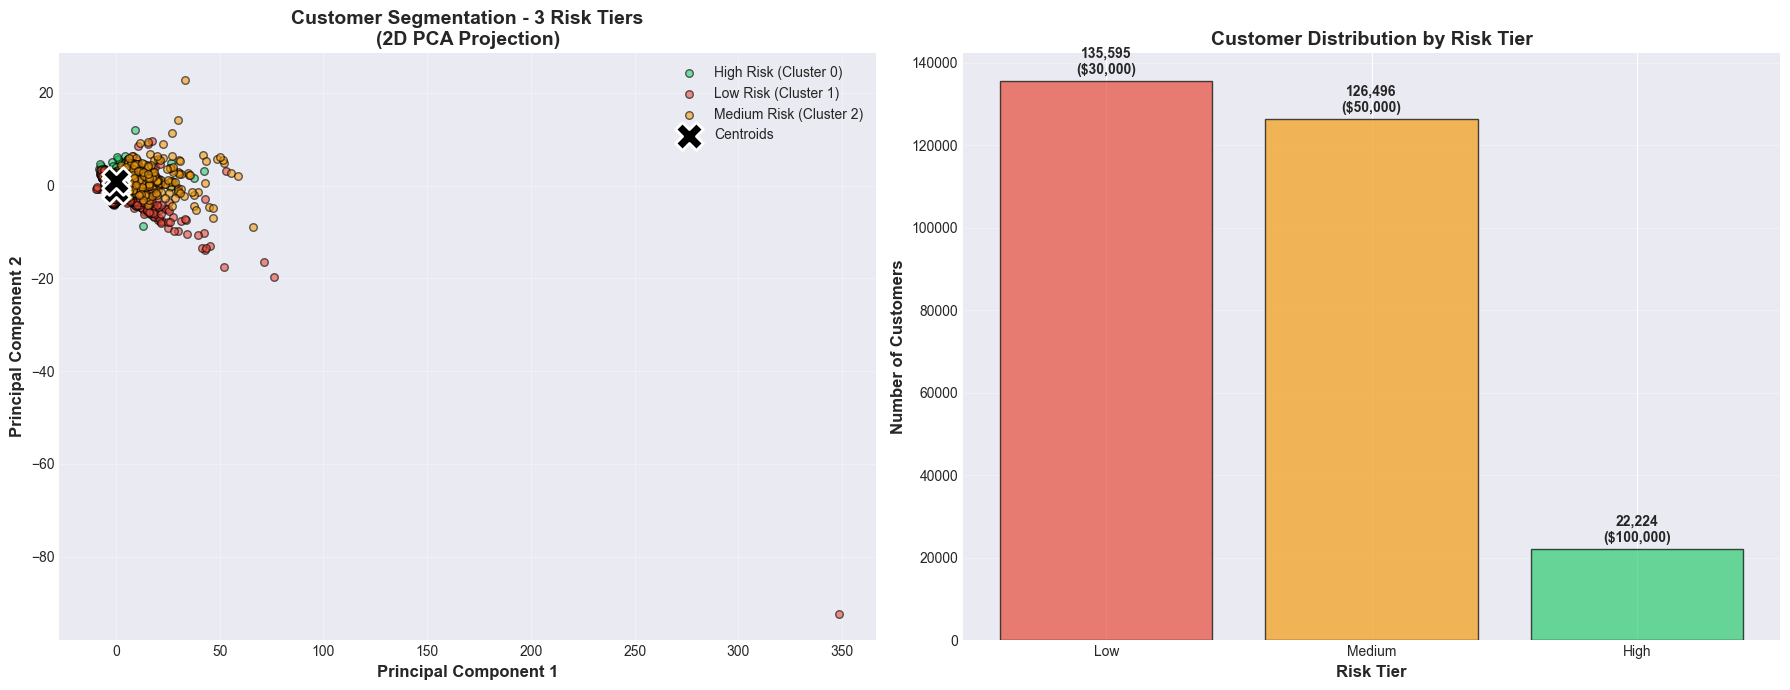


✓ Clustering visualization complete


In [9]:
print(f"\n{'='*60}")
print("CLUSTER VISUALIZATION")
print(f"{'='*60}")

# Visualize clusters in 2D PCA space
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Clusters with centroids
colors = ['#e74c3c', '#f39c12', '#2ecc71']  # Red, Orange, Green
tier_names = ['Low', 'Medium', 'High']

for cluster in range(3):
    mask = cluster_labels == cluster
    tier = cluster_to_tier[cluster]
    color_idx = tier_names.index(tier)
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=colors[color_idx], label=f'{tier} Risk (Cluster {cluster})',
                   alpha=0.6, edgecolors='k', s=30)

# Plot centroids (transform to PCA space)
centroids_pca = pca.transform(kmeans.cluster_centers_)
axes[0].scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
               c='black', marker='X', s=400, edgecolors='white', 
               linewidths=2, label='Centroids', zorder=5)

axes[0].set_xlabel('Principal Component 1', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Principal Component 2', fontsize=12, fontweight='bold')
axes[0].set_title('Customer Segmentation - 3 Risk Tiers\n(2D PCA Projection)', 
                 fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(alpha=0.3)

# Plot 2: Credit limit distribution
tier_order = ['Low', 'Medium', 'High']
tier_colors = ['#e74c3c', '#f39c12', '#2ecc71']
tier_counts = [tier_summary.loc[tier, 'Customer_Count'] for tier in tier_order]
tier_limits = [tier_summary.loc[tier, 'Credit_Limit'] for tier in tier_order]

bars = axes[1].bar(tier_order, tier_counts, color=tier_colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Risk Tier', fontsize=12, fontweight='bold')
axes[1].set_title('Customer Distribution by Risk Tier', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, count, limit) in enumerate(zip(bars, tier_counts, tier_limits)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 1000,
                f'{count:,}\n(${limit:,})',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Clustering visualization complete")


RISK TIER DISTRIBUTION PIE CHART


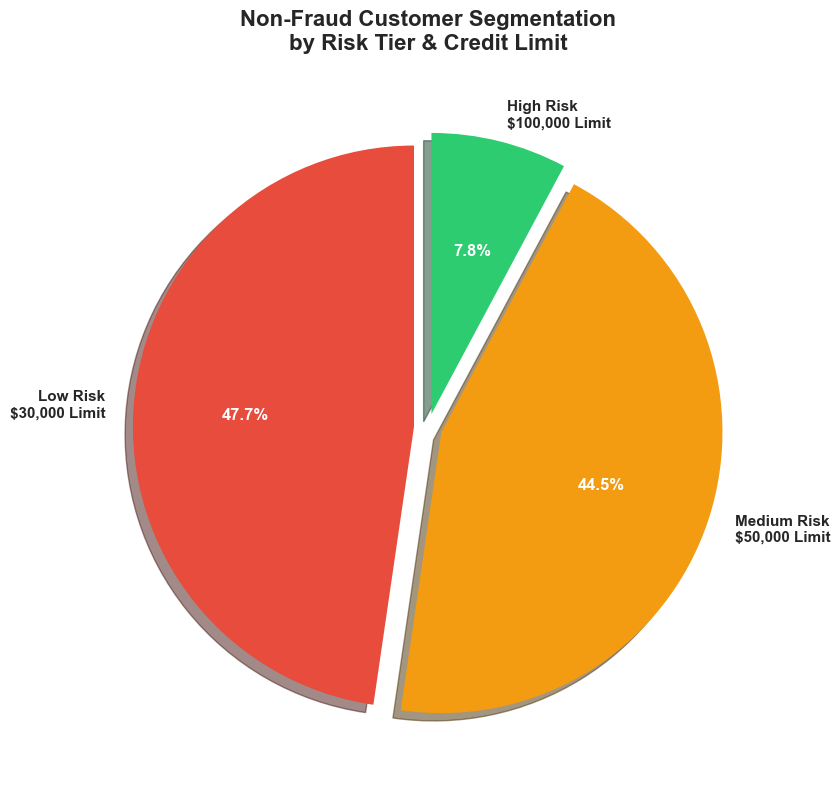

In [10]:
print(f"\n{'='*60}")
print("RISK TIER DISTRIBUTION PIE CHART")
print(f"{'='*60}")

# Create pie chart for risk tiers
fig, ax = plt.subplots(figsize=(10, 8))

tier_order = ['Low', 'Medium', 'High']
tier_colors = ['#e74c3c', '#f39c12', '#2ecc71']
tier_counts = [tier_summary.loc[tier, 'Customer_Count'] for tier in tier_order]
tier_limits = [tier_summary.loc[tier, 'Credit_Limit'] for tier in tier_order]

labels = [f'{tier} Risk\n${limit:,} Limit' for tier, limit in zip(tier_order, tier_limits)]

wedges, texts, autotexts = ax.pie(tier_counts, labels=labels, colors=tier_colors,
                                    autopct='%1.1f%%', startangle=90, 
                                    explode=(0.05, 0.05, 0.05), shadow=True,
                                    textprops={'fontsize': 11, 'fontweight': 'bold'})

# Enhance percentage text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

ax.set_title('Non-Fraud Customer Segmentation\nby Risk Tier & Credit Limit', 
            fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

In [11]:
print(f"\n{'='*60}")
print("EXPORT CUSTOMER SEGMENTATION DATA")
print(f"{'='*60}")

# Create final output dataframe with customer segmentation
output_df = df_non_fraud[['id', 'Cluster', 'Risk_Tier', 'Credit_Limit']].copy()

# Save to CSV
output_filename = 'customer_segmentation_credit_limits.csv'
output_df.to_csv(output_filename, index=False)

print(f"\n✓ Customer segmentation data exported to: {output_filename}")
print(f"\nFile contains:")
print(f"  - Total Customers: {len(output_df):,}")
print(f"  - Columns: {output_df.columns.tolist()}")
print(f"\nSample data:")
print(output_df.head(10))

# Summary statistics
print(f"\n{'='*60}")
print("FINAL SUMMARY STATISTICS")
print(f"{'='*60}")
print(f"\nCredit Limit Distribution:")
print(output_df['Credit_Limit'].value_counts().sort_index())
print(f"\nRisk Tier Distribution:")
print(output_df['Risk_Tier'].value_counts())


EXPORT CUSTOMER SEGMENTATION DATA

✓ Customer segmentation data exported to: customer_segmentation_credit_limits.csv

File contains:
  - Total Customers: 284,315
  - Columns: ['id', 'Cluster', 'Risk_Tier', 'Credit_Limit']

Sample data:
   id  Cluster Risk_Tier  Credit_Limit
0   0        1       Low         30000
1   1        2    Medium         50000
2   2        1       Low         30000
3   3        1       Low         30000
4   4        1       Low         30000
5   5        1       Low         30000
6   6        2    Medium         50000
7   7        1       Low         30000
8   8        1       Low         30000
9   9        1       Low         30000

FINAL SUMMARY STATISTICS

Credit Limit Distribution:
Credit_Limit
30000     135595
50000     126496
100000     22224
Name: count, dtype: int64

Risk Tier Distribution:
Risk_Tier
Low       135595
Medium    126496
High       22224
Name: count, dtype: int64


## Key Findings

### Customer Segmentation Strategy
- **Clustering Method**: K-Means with K=3 (Low, Medium, High Risk)
- **Data Subset**: Only non-fraud transactions (Class = 0)
- **Credit Limit Assignment**:
  - **Low Risk**: $30,000 credit limit
  - **Medium Risk**: $50,000 credit limit  
  - **High Risk**: $100,000 credit limit

### Business Benefits
1. **Risk-Based Credit Assignment**: Customers are assigned credit limits based on their transaction behavior patterns
2. **Data-Driven Decision Making**: Clustering reveals natural customer segments in the data
3. **Scalable Approach**: Can be easily updated as new customer data becomes available
4. **Fraud Exclusion**: Only legitimate customers are considered for credit limit assignment

### Next Steps
- Monitor credit utilization patterns within each tier
- Periodically re-cluster to capture changing customer behaviors
- Consider additional features (transaction frequency, amounts, etc.) for more refined segmentation